In [1]:
import time

import numpy as np
# np.random.seed(1234)
from functools import reduce
import math as m

# import DNN frameworks
import tensorflow as tf
import keras

# import high level optimizers, models and layers
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import InputLayer

# for CNN
from keras.layers import Conv2D, MaxPooling2D
# for RNN
from keras.layers import LSTM

# for utility functionality
from keras.layers import Dense, Dropout, Flatten

from keras.preprocessing import sequence
from keras.layers.embeddings import Embedding

# utility for datasets and training
# from keras.utils.training_utils import multi_gpu_model
from keras.datasets import imdb
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
# imports tensorflow
# from keras import backend as K

Using TensorFlow backend.


In [2]:
def build_cnn(model, w_init=None, n_layers=(4,2,1),poolsize=(2,2),n_filters_first=32):    
    DEBUG=0
    
    # check for weight initialization -> apply Glorotuniform
    if w_init is None:
        w_init = [keras.initializers.glorot_uniform()] * sum(n_layers)
    
    # set up input layer of CNN
    model.add(InputLayer(input_shape=(imsize, imsize, n_colors)))
    # initialize counter
    count=0
    
    # add the rest of the hidden layers
    for idx, n_layer in enumerate(n_layers):
        for ilay in range(n_layer):
            model.add(Conv2D(n_filters_first*(2 ** idx), 
                             (3, 3),
                             input_shape=(imsize, imsize, n_colors),
                             kernel_initializer=w_init[count], activation='relu'))
            if DEBUG:
                print(model.output_shape)
                print(idx, " and ", ilay)
            count+=1

        # create a network at the end with a max pooling
        model.add(MaxPooling2D(pool_size=poolsize))
    return model
def poly_decay(epoch):
    # initialize the maximum number of epochs, base learning rate,
    # and power of the polynomial
    maxEpochs = NUM_EPOCHS
    baseLR = INIT_LR
    power = 1.0
    # compute the new learning rate based on polynomial decay
    alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
    # return the new learning rate
    return alpha


In [3]:
from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
# number of gpus
G = 1
print(get_available_gpus())
print(device_lib.list_local_devices())


['/gpu:0', '/gpu:1']
[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18273343555873161807
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 234684416
locality {
  bus_id: 1
}
incarnation: 15817859456517356540
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:03:00.0"
, name: "/gpu:1"
device_type: "GPU"
memory_limit: 234946560
locality {
  bus_id: 1
}
incarnation: 8973268339811720805
physical_device_desc: "device: 1, name: GeForce GTX 1080, pci bus id: 0000:04:00.0"
]


In [24]:
# Creates a graph.
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))

[[ 22.  28.]
 [ 49.  64.]]


# First CNN Training and Validation

This trains the example CNN using Keras and tensorflow on NVIDIA 1080X GPU for MNIST dataset. It is not very deep, and is a proof-of-concept.

We log and show the code for showing the training loss over epoch.
Next we will train an LSTM for the IMDB dataset and then finally, we will combine the two to show training on a real dataset.

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
print(len(mnist))
print(type(mnist))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
3
<class 'tensorflow.contrib.learn.python.learn.datasets.base.Datasets'>


In [5]:
n_colors = 1
imsize=28

X_train= mnist.train.images
y_train = mnist.train.labels
# y_train=keras.utils.np_utils.to_categorical(y_train, num_classes=10)
X_test = mnist.test.images
y_test = mnist.test.labels

# reshape into correct size to feed into NN
X_train = np.reshape(X_train, [-1, imsize, imsize, n_colors])
X_test = np.reshape(X_test, [-1, imsize, imsize, n_colors])

imsize=X_train.shape[1]
print("im size is : ", imsize)
print(X_train.shape)
print(y_train.shape)

im size is :  28
(55000, 28, 28, 1)
(55000, 10)


In [6]:
w_init=None
model = Sequential()
model = build_cnn(model, w_init=w_init, n_layers=(2,1), n_filters_first=16)
print(model.output)

# to test training of this network, add a softmax at the end
model.add(Flatten())
print(model.output_shape)
model.add(Dense(800, activation='relu'))
print(model.output_shape)
model.add(Dense(10, activation='softmax'))
print(model.output_shape)

# ADAM
ADAM = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=ADAM, metrics=["accuracy"])

Tensor("max_pooling2d_2/MaxPool:0", shape=(?, 5, 5, 32), dtype=float32)
(None, 800)
(None, 800)
(None, 10)


In [ ]:
NUM_EPOCHS = 100
# construct the image generator for data augmentation and construct
# the set of callbacks
aug = ImageDataGenerator(width_shift_range=0.1,
    height_shift_range=0.1, horizontal_flip=True,
    fill_mode="nearest")
callbacks = [LearningRateScheduler(poly_decay)]
INIT_LR = 5e-3
 
HH = model.fit_generator(
    aug.flow(X_train, y_train, batch_size=64 * G), # adds augmentation to data using generator
    validation_data=(X_test, y_test),  
    steps_per_epoch=len(X_train) // (64 * G),    #
    epochs=NUM_EPOCHS,
    callbacks=callbacks, verbose=2)

Epoch 1/100
17s - loss: 0.3016 - acc: 0.9014 - val_loss: 0.1088 - val_acc: 0.9654
Epoch 2/100
11s - loss: 0.1260 - acc: 0.9615 - val_loss: 0.1114 - val_acc: 0.9651
Epoch 3/100
11s - loss: 0.1038 - acc: 0.9680 - val_loss: 0.0850 - val_acc: 0.9735
Epoch 4/100
11s - loss: 0.0918 - acc: 0.9715 - val_loss: 0.0648 - val_acc: 0.9792
Epoch 5/100
11s - loss: 0.0883 - acc: 0.9732 - val_loss: 0.0626 - val_acc: 0.9800
Epoch 6/100
11s - loss: 0.0862 - acc: 0.9731 - val_loss: 0.0690 - val_acc: 0.9799
Epoch 7/100
11s - loss: 0.0790 - acc: 0.9764 - val_loss: 0.0677 - val_acc: 0.9791
Epoch 8/100
11s - loss: 0.0800 - acc: 0.9754 - val_loss: 0.0559 - val_acc: 0.9833
Epoch 9/100
11s - loss: 0.0766 - acc: 0.9775 - val_loss: 0.0711 - val_acc: 0.9757
Epoch 10/100
11s - loss: 0.0736 - acc: 0.9774 - val_loss: 0.0510 - val_acc: 0.9847
Epoch 11/100
11s - loss: 0.0720 - acc: 0.9787 - val_loss: 0.0490 - val_acc: 0.9852
Epoch 12/100


In [ ]:
import matplotlib.pyplot as plt
H = HH.history
print(HH.params)
print(H.keys())

# plot the training loss and accuracy
N = np.arange(0, len(H["loss"]))
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H["loss"], label="train_loss")
plt.plot(N, H["val_loss"], label="test_loss")
plt.plot(N, H["acc"], label="train_acc")
plt.plot(N, H["val_acc"], label="test_acc")
plt.title("VGG Net on MNIST")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

print(model.summary())

## Second Test Building The LSTM

We now want to build the RNN layers using LSTM. First show an example of the LSTM running sequence classification on the imdb dataset.

In [42]:
np.random.seed(7)
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(25000,)
(25000,)
(25000,)
(25000,)


In [48]:
# truncate and pad input sequences
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_test.shape)

# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

(25000, 500)
(25000, 500)


In [ ]:
# print(model.fit())
HH = model.fit(
    x=X_train, 
    y=y_train, 
    validation_data=(X_test, y_test), 
#     steps_per_epoch=len(X_train) // (64 * G),
    epochs=NUM_EPOCHS, 
    batch_size=64*G)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 25000 samples, validate on 25000 samples
Epoch 1/100


{'epochs': 100, 'steps': 859, 'verbose': 2, 'do_validation': True, 'metrics': ['loss', 'acc', 'val_loss', 'val_acc']}
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


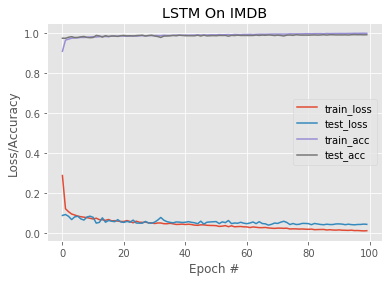

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


In [57]:
H = HH.history
print(HH.params)
print(H.keys())

# plot the training loss and accuracy
N = np.arange(0, len(H["loss"]))
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H["loss"], label="train_loss")
plt.plot(N, H["val_loss"], label="test_loss")
plt.plot(N, H["acc"], label="train_acc")
plt.plot(N, H["val_acc"], label="test_acc")
plt.title("LSTM On IMDB")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

print(model.summary())